In [1]:
from pyspark.sql import SparkSession

In [2]:
# Import Necessary Libraries
import numpy as np
import matplotlib.pyplot as plt 
from pyspark.sql import functions as func
from pyspark import SparkContext
from pyspark.sql.types import StringType, IntegerType
import plotly.offline as po
import plotly.graph_objs as go
%matplotlib inline
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline
import seaborn as sns
import pandas as pd

In [3]:
spark = SparkSession.builder.appName("Churn").getOrCreate()

22/04/13 17:24:57 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [4]:
df_Telco = spark.read.csv("Telco_Dataset.csv", inferSchema= True, header=True)
df_Telco.printSchema()

root
 |-- customerID: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- SeniorCitizen: integer (nullable = true)
 |-- Dependents: string (nullable = true)
 |-- tenure: integer (nullable = true)
 |-- PhoneService: string (nullable = true)
 |-- MultipleLines: string (nullable = true)
 |-- OnlineBackup: string (nullable = true)
 |-- DeviceProtection: string (nullable = true)
 |-- TechSupport: string (nullable = true)
 |-- StreamingMovies: string (nullable = true)
 |-- Contract: string (nullable = true)
 |-- PaperlessBilling: string (nullable = true)
 |-- PaymentMethod: string (nullable = true)
 |-- TotalCharges: string (nullable = true)
 |-- Churn: string (nullable = true)



In [5]:
from pyspark.sql.types import DoubleType

df_Telco = df_Telco.withColumn("TotalCharges_Double",func.col("TotalCharges").cast(DoubleType()))

In [6]:
#To show Null Values
from pyspark.sql.functions import isnan, when, count, col, translate
df_Telco.select([count(when(col(c).isNull(), c)).alias(c) for c in df_Telco.columns]).show()

+----------+------+-------------+----------+------+------------+-------------+------------+----------------+-----------+---------------+--------+----------------+-------------+------------+-----+-------------------+
|customerID|gender|SeniorCitizen|Dependents|tenure|PhoneService|MultipleLines|OnlineBackup|DeviceProtection|TechSupport|StreamingMovies|Contract|PaperlessBilling|PaymentMethod|TotalCharges|Churn|TotalCharges_Double|
+----------+------+-------------+----------+------+------------+-------------+------------+----------------+-----------+---------------+--------+----------------+-------------+------------+-----+-------------------+
|         0|     0|            0|         0|     0|           0|            0|           0|               0|          0|              0|       0|               0|            0|           0|    0|                 11|
+----------+------+-------------+----------+------+------------+-------------+------------+----------------+-----------+---------------+

In [7]:
#To Handle Null Values in TotalCharges column, we replaced them with mean using imputer function

from pyspark.ml.feature import Imputer

imptr = Imputer(inputCols=['TotalCharges_Double'], outputCols=['TotalCharges_Double']).setStrategy('mean')

df_Telco = imptr.fit(df_Telco).transform(df_Telco)

In [8]:
df_Telco.select([count(when(col(c).isNull(), c)).alias(c) for c in df_Telco.columns]).show()

+----------+------+-------------+----------+------+------------+-------------+------------+----------------+-----------+---------------+--------+----------------+-------------+------------+-----+-------------------+
|customerID|gender|SeniorCitizen|Dependents|tenure|PhoneService|MultipleLines|OnlineBackup|DeviceProtection|TechSupport|StreamingMovies|Contract|PaperlessBilling|PaymentMethod|TotalCharges|Churn|TotalCharges_Double|
+----------+------+-------------+----------+------+------------+-------------+------------+----------------+-----------+---------------+--------+----------------+-------------+------------+-----+-------------------+
|         0|     0|            0|         0|     0|           0|            0|           0|               0|          0|              0|       0|               0|            0|           0|    0|                  0|
+----------+------+-------------+----------+------+------------+-------------+------------+----------------+-----------+---------------+

In [9]:
df_Telco.printSchema()

root
 |-- customerID: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- SeniorCitizen: integer (nullable = true)
 |-- Dependents: string (nullable = true)
 |-- tenure: integer (nullable = true)
 |-- PhoneService: string (nullable = true)
 |-- MultipleLines: string (nullable = true)
 |-- OnlineBackup: string (nullable = true)
 |-- DeviceProtection: string (nullable = true)
 |-- TechSupport: string (nullable = true)
 |-- StreamingMovies: string (nullable = true)
 |-- Contract: string (nullable = true)
 |-- PaperlessBilling: string (nullable = true)
 |-- PaymentMethod: string (nullable = true)
 |-- TotalCharges: string (nullable = true)
 |-- Churn: string (nullable = true)
 |-- TotalCharges_Double: double (nullable = true)



In [10]:
df_Telco.select(['SeniorCitizen', 'tenure', 'TotalCharges_Double']).describe().show()

+-------+------------------+------------------+-------------------+
|summary|     SeniorCitizen|            tenure|TotalCharges_Double|
+-------+------------------+------------------+-------------------+
|  count|              7043|              7043|               7043|
|   mean|0.1621468124378816| 32.37114865824223| 2283.3004408418697|
| stddev|0.3686116056100135|24.559481023094442| 2265.0002578033286|
|    min|                 0|                 0|               18.8|
|    max|                 1|                72|             8684.8|
+-------+------------------+------------------+-------------------+



In [11]:
churn = df_Telco.groupby("Churn").count()\
.filter((df_Telco.Churn == 'Yes')|(df_Telco.Churn == 'No'))



Total = churn.groupBy().sum('count').collect()[0][0]

churn.show()
print(Total)

+-----+-----+
|Churn|count|
+-----+-----+
|   No| 5174|
|  Yes| 1869|
+-----+-----+

7043


# Churn Rate Calculation

In [12]:
churn_yes = df_Telco.groupby("Churn").count()\
.filter((df_Telco.Churn=="Yes"))

Churned = churn_yes.groupBy().sum('count').collect()[0][0]

churn_yes.show()
print(Churned)


churn_no = df_Telco.groupby("Churn").count()\
.filter((df_Telco.Churn != 'Yes'))

churn_no.show()

customers_not_churned = churn_no.groupBy().sum('count').collect()[0][0]

print( "Customer Churn rate (%):" , (Churned / Total)*100)

+-----+-----+
|Churn|count|
+-----+-----+
|  Yes| 1869|
+-----+-----+

1869
+-----+-----+
|Churn|count|
+-----+-----+
|   No| 5174|
+-----+-----+



Customer Churn rate (%): 26.536987079369588


# Mean, Median and Standard Deviation by Churn Category

In [14]:
#Mean
df_Telco.groupby(df_Telco.Churn).agg(func.mean("SeniorCitizen"), func.mean("tenure"),\
func.mean("TotalCharges_Double")).show()

#Standard Deviation
df_Telco.groupby(df_Telco.Churn).agg(func.stddev("SeniorCitizen"), func.stddev("tenure"),\
func.stddev("TotalCharges_Double")).show()

#Median
df_Telco.groupby(df_Telco.Churn).agg(
    func.percentile_approx("SeniorCitizen", 0.5).alias("SeniorCitizen median"),\
    func.percentile_approx("tenure", 0.5).alias("tenure median"),\
    func.percentile_approx("TotalCharges_Double", 0.5).alias("TotalCharges median")).show()

+-----+-------------------+------------------+------------------------+
|Churn| avg(SeniorCitizen)|       avg(tenure)|avg(TotalCharges_Double)|
+-----+-------------------+------------------+------------------------+
|   No|0.12872052570545034| 37.56996521066873|       2554.765772100754|
|  Yes| 0.2546816479400749|17.979133226324237|      1531.7960941680035|
+-----+-------------------+------------------+------------------------+

+-----+--------------------------+-------------------+--------------------------------+
|Churn|stddev_samp(SeniorCitizen)|stddev_samp(tenure)|stddev_samp(TotalCharges_Double)|
+-----+--------------------------+-------------------+--------------------------------+
|   No|       0.33492272563063946|  24.11377669070408|               2327.012699489832|
|  Yes|        0.4357987175972202|  19.53112305451955|              1890.8229944644042|
+-----+--------------------------+-------------------+--------------------------------+

+-----+--------------------+----------

# Pivot Tables

In [15]:
#Number of people who churned and didn't churn based on Gender
pivot_gender_churn = df_Telco.groupby('gender').pivot('Churn').count()
pivot_gender_churn.show(truncate= False)

#Number of people who churned and didn't churn based on Contract Type
pivot_Contract_Churn = df_Telco.groupby('Contract').pivot('Churn').count()
pivot_Contract_Churn.show(truncate= False)

#Number of people who churned and didn't churn based on whether they had TechSupport
pivot_TechSupport_Churn = df_Telco.groupby('TechSupport').pivot('Churn').count()
pivot_TechSupport_Churn.show(truncate= False)

#Number of people who churned and didn't churn based on whether they had Streaming Movies
pivot_StreamingMovies_Churn = df_Telco.groupby('StreamingMovies').pivot('Churn').count()
pivot_StreamingMovies_Churn.show(truncate= False)

#Number of people who churned and didn't churn based on whether they had Device Protection
pivot_DeviceProtection_Churn = df_Telco.groupby('DeviceProtection').pivot('Churn').count()
pivot_DeviceProtection_Churn.show(truncate= False)

#Number of people who churned and didn't churn based on whether they had Online backup
pivot_OnlineBackup_Churn = df_Telco.groupby('OnlineBackup').pivot('Churn').count()
pivot_OnlineBackup_Churn.show(truncate= False)


+------+----+---+
|gender|No  |Yes|
+------+----+---+
|Female|2549|939|
|Male  |2625|930|
+------+----+---+



+--------------+----+----+
|Contract      |No  |Yes |
+--------------+----+----+
|Month-to-month|2220|1655|
|One year      |1307|166 |
|Two year      |1647|48  |
+--------------+----+----+



+-------------------+----+----+
|TechSupport        |No  |Yes |
+-------------------+----+----+
|No                 |2027|1446|
|Yes                |1734|310 |
|No internet service|1413|113 |
+-------------------+----+----+



+-------------------+----+---+
|StreamingMovies    |No  |Yes|
+-------------------+----+---+
|No                 |1847|938|
|Yes                |1914|818|
|No internet service|1413|113|
+-------------------+----+---+



+-------------------+----+----+
|DeviceProtection   |No  |Yes |
+-------------------+----+----+
|No                 |1884|1211|
|Yes                |1877|545 |
|No internet service|1413|113 |
+-------------------+----+----+



+-------------------+----+----+
|OnlineBackup       |No  |Yes |
+-------------------+----+----+
|No                 |1855|1233|
|Yes                |1906|523 |
|No internet service|1413|113 |
+-------------------+----+----+



# Data Visualisation

1.Barchart for Tenure

indexers = [StringIndexer(inputCol=column, outputCol=column+"_index").fit(df_Telco) for column in list(set(df_Telco.columns)-set(['customerID'])) ]


pipeline = Pipeline(stages=indexers)
df_r = pipeline.fit(df_Telco).transform(df_Telco)

df_r.show()

for _ in df_r.columns:

  df_r = df_r.withColumn(_,col(_).cast(DoubleType()))

print(df_r.dtypes)

Row(CAST(tenure AS INT)=1, count=613)
Row(CAST(tenure AS INT)=72, count=362)
Row(CAST(tenure AS INT)=2, count=238)
Row(CAST(tenure AS INT)=3, count=200)
Row(CAST(tenure AS INT)=4, count=176)
Row(CAST(tenure AS INT)=71, count=170)
Row(CAST(tenure AS INT)=5, count=133)
Row(CAST(tenure AS INT)=7, count=131)
Row(CAST(tenure AS INT)=8, count=123)
Row(CAST(tenure AS INT)=9, count=119)
Row(CAST(tenure AS INT)=70, count=119)
Row(CAST(tenure AS INT)=12, count=117)
Row(CAST(tenure AS INT)=10, count=116)
Row(CAST(tenure AS INT)=6, count=110)
Row(CAST(tenure AS INT)=13, count=109)
Row(CAST(tenure AS INT)=68, count=100)
Row(CAST(tenure AS INT)=15, count=99)
Row(CAST(tenure AS INT)=11, count=99)
Row(CAST(tenure AS INT)=67, count=98)
Row(CAST(tenure AS INT)=18, count=97)
Row(CAST(tenure AS INT)=69, count=95)
Row(CAST(tenure AS INT)=24, count=94)
Row(CAST(tenure AS INT)=22, count=90)
Row(CAST(tenure AS INT)=66, count=89)
Row(CAST(tenure AS INT)=35, count=88)
Row(CAST(tenure AS INT)=17, count=87)
Row(C

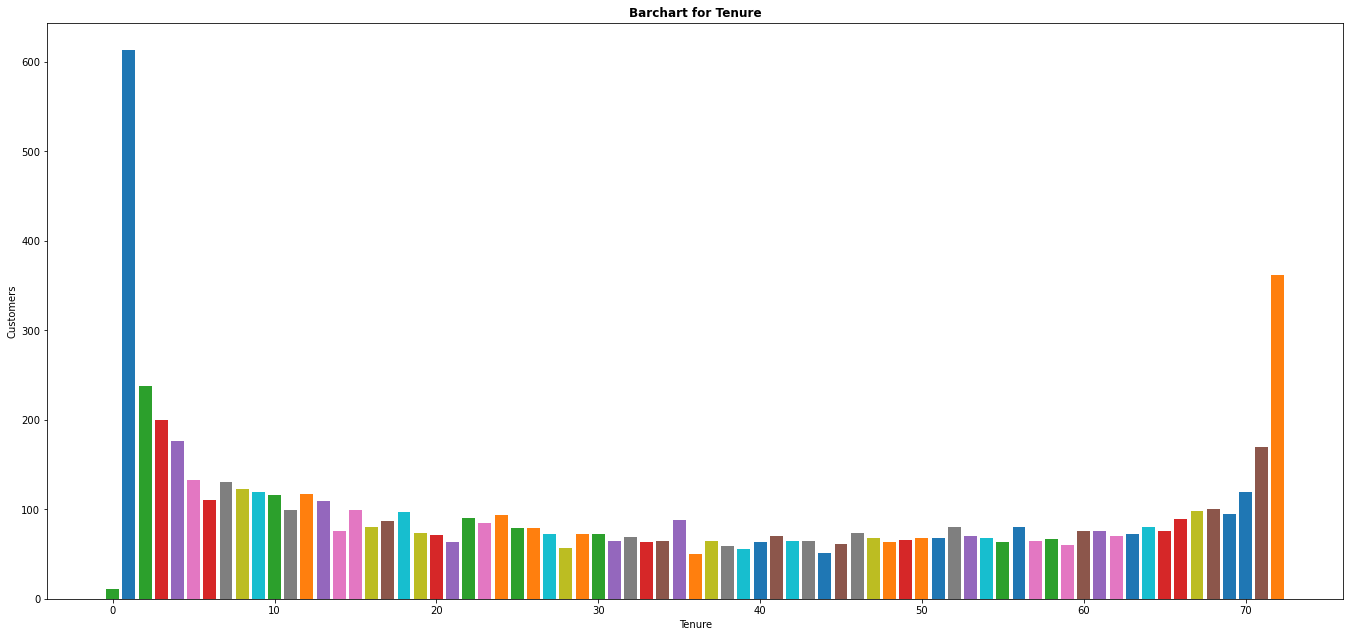

In [16]:
#barchart for tenure

data = df_Telco.groupBy(df_Telco.tenure.cast(IntegerType())).count().orderBy("count", ascending=False).collect()
fig = plt.figure()
ax = fig.add_axes([0,0,3,2])
# add_axes([left, bottom, width, height]) to add an axes onto a fig . 
# This function enables arbitrary layouts of axes on fig by taking the dimensions ( [left, bottom, width, height] ) of the new axes
for _ in data:

  ax.bar(_[0], _[1])

  print(_)

   
print(data) 


plt.xlabel('Tenure')

plt.ylabel('Customers')
  

plt.title('Barchart for Tenure',fontweight ="bold")

plt.show()

Row(TotalCharges_Double=29)
Row(TotalCharges_Double=1889)
Row(TotalCharges_Double=108)
Row(TotalCharges_Double=1840)
Row(TotalCharges_Double=151)
Row(TotalCharges_Double=820)
Row(TotalCharges_Double=1949)
Row(TotalCharges_Double=301)
Row(TotalCharges_Double=3046)
Row(TotalCharges_Double=3487)
Row(TotalCharges_Double=587)
Row(TotalCharges_Double=326)
Row(TotalCharges_Double=5681)
Row(TotalCharges_Double=5036)
Row(TotalCharges_Double=2686)
Row(TotalCharges_Double=7895)
Row(TotalCharges_Double=1022)
Row(TotalCharges_Double=7382)
Row(TotalCharges_Double=528)
Row(TotalCharges_Double=1862)
Row(TotalCharges_Double=39)
Row(TotalCharges_Double=202)
Row(TotalCharges_Double=20)
Row(TotalCharges_Double=3505)
Row(TotalCharges_Double=2970)
Row(TotalCharges_Double=1530)
Row(TotalCharges_Double=4749)
Row(TotalCharges_Double=30)
Row(TotalCharges_Double=6369)
Row(TotalCharges_Double=1093)
Row(TotalCharges_Double=6766)
Row(TotalCharges_Double=181)
Row(TotalCharges_Double=1874)
Row(TotalCharges_Double=20)

<Figure size 432x288 with 0 Axes>

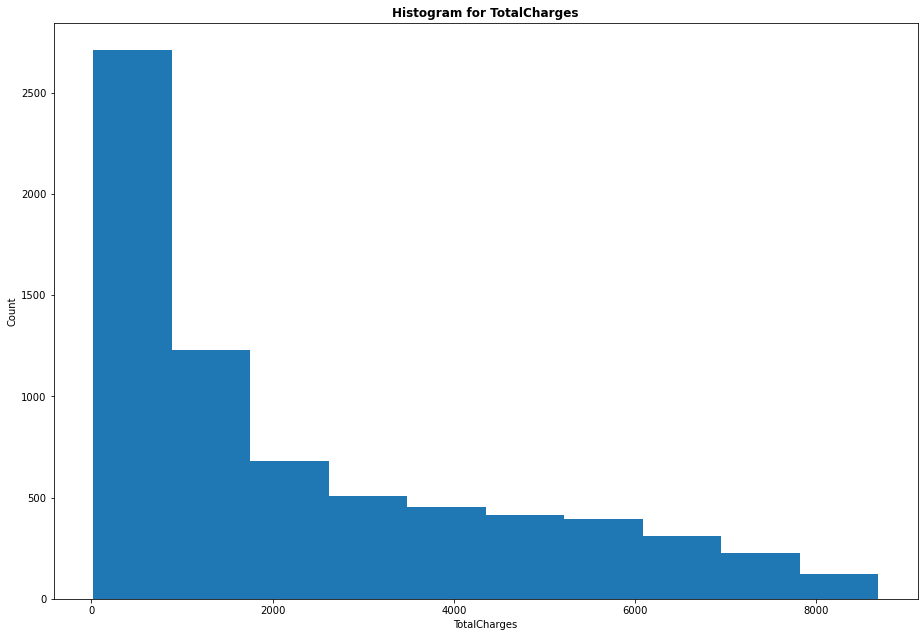

In [142]:
#histogram for tenure attribute
plt.clf()

data = df_Telco.select(df_Telco.TotalCharges_Double.cast(IntegerType())).collect()

fig = plt.figure()

ax = fig.add_axes([0,0,2,2])


tenure = []

for _ in data:

  TotalCharges_Double.append(_[0])

  print(_)

counts, bins = np.histogram(data) # Auto range data, np is a numeric library

print(bins)

print(counts)

plt.hist(bins[:-1], bins, weights=counts)   

 

plt.xlabel('TotalCharges')

plt.ylabel('Count')
  

plt.title('Histogram for TotalCharges',fontweight ="bold")


plt.show()

In [17]:
customerIDIndexer = StringIndexer(inputCol="customerID", outputCol="customerID_feature")
customerIDIndexer_fit = customerIDIndexer.fit(df_Telco)
df_Telco_training = customerIDIndexer_fit.transform(df_Telco)

print(df_Telco_training.dtypes)

[('customerID', 'string'), ('gender', 'string'), ('SeniorCitizen', 'int'), ('Dependents', 'string'), ('tenure', 'int'), ('PhoneService', 'string'), ('MultipleLines', 'string'), ('OnlineBackup', 'string'), ('DeviceProtection', 'string'), ('TechSupport', 'string'), ('StreamingMovies', 'string'), ('Contract', 'string'), ('PaperlessBilling', 'string'), ('PaymentMethod', 'string'), ('TotalCharges', 'string'), ('Churn', 'string'), ('TotalCharges_Double', 'double'), ('customerID_feature', 'double')]


In [18]:
ChurnIndexer = StringIndexer(inputCol="Churn", outputCol="ChurnLabel")
ChurnIndexer_fit = ChurnIndexer.fit(df_Telco_training)
df_Telco_training = ChurnIndexer_fit.transform(df_Telco_training)

print(df_Telco_training.dtypes)

[('customerID', 'string'), ('gender', 'string'), ('SeniorCitizen', 'int'), ('Dependents', 'string'), ('tenure', 'int'), ('PhoneService', 'string'), ('MultipleLines', 'string'), ('OnlineBackup', 'string'), ('DeviceProtection', 'string'), ('TechSupport', 'string'), ('StreamingMovies', 'string'), ('Contract', 'string'), ('PaperlessBilling', 'string'), ('PaymentMethod', 'string'), ('TotalCharges', 'string'), ('Churn', 'string'), ('TotalCharges_Double', 'double'), ('customerID_feature', 'double'), ('ChurnLabel', 'double')]


In [19]:
genderIndexer = StringIndexer(inputCol="gender", outputCol="Gender_feature")
genderIndexer_fit = genderIndexer.fit(df_Telco_training)
df_Telco_training = genderIndexer_fit.transform(df_Telco_training)

print(df_Telco_training.dtypes)

[('customerID', 'string'), ('gender', 'string'), ('SeniorCitizen', 'int'), ('Dependents', 'string'), ('tenure', 'int'), ('PhoneService', 'string'), ('MultipleLines', 'string'), ('OnlineBackup', 'string'), ('DeviceProtection', 'string'), ('TechSupport', 'string'), ('StreamingMovies', 'string'), ('Contract', 'string'), ('PaperlessBilling', 'string'), ('PaymentMethod', 'string'), ('TotalCharges', 'string'), ('Churn', 'string'), ('TotalCharges_Double', 'double'), ('customerID_feature', 'double'), ('ChurnLabel', 'double'), ('Gender_feature', 'double')]


In [20]:
ContractIndexer = StringIndexer(inputCol="Contract", outputCol="Contract_feature")
ContractIndexer_fit = ContractIndexer.fit(df_Telco_training)
df_Telco_training = ContractIndexer_fit.transform(df_Telco_training)

print(df_Telco_training.dtypes)

[('customerID', 'string'), ('gender', 'string'), ('SeniorCitizen', 'int'), ('Dependents', 'string'), ('tenure', 'int'), ('PhoneService', 'string'), ('MultipleLines', 'string'), ('OnlineBackup', 'string'), ('DeviceProtection', 'string'), ('TechSupport', 'string'), ('StreamingMovies', 'string'), ('Contract', 'string'), ('PaperlessBilling', 'string'), ('PaymentMethod', 'string'), ('TotalCharges', 'string'), ('Churn', 'string'), ('TotalCharges_Double', 'double'), ('customerID_feature', 'double'), ('ChurnLabel', 'double'), ('Gender_feature', 'double'), ('Contract_feature', 'double')]


In [21]:
TechSupportIndexer = StringIndexer(inputCol="TechSupport", outputCol="TechSupport_feature")
TechSupportIndexer_fit = TechSupportIndexer.fit(df_Telco_training)
df_Telco_training = TechSupportIndexer_fit.transform(df_Telco_training)

print(df_Telco_training.dtypes)

[('customerID', 'string'), ('gender', 'string'), ('SeniorCitizen', 'int'), ('Dependents', 'string'), ('tenure', 'int'), ('PhoneService', 'string'), ('MultipleLines', 'string'), ('OnlineBackup', 'string'), ('DeviceProtection', 'string'), ('TechSupport', 'string'), ('StreamingMovies', 'string'), ('Contract', 'string'), ('PaperlessBilling', 'string'), ('PaymentMethod', 'string'), ('TotalCharges', 'string'), ('Churn', 'string'), ('TotalCharges_Double', 'double'), ('customerID_feature', 'double'), ('ChurnLabel', 'double'), ('Gender_feature', 'double'), ('Contract_feature', 'double'), ('TechSupport_feature', 'double')]


In [22]:
StreamingMoviesIndexer = StringIndexer(inputCol="StreamingMovies", outputCol="StreamingMovies_feature")
StreamingMoviesIndexer_fit = StreamingMoviesIndexer.fit(df_Telco_training)
df_Telco_training = StreamingMoviesIndexer_fit.transform(df_Telco_training)

print(df_Telco_training.dtypes)

[('customerID', 'string'), ('gender', 'string'), ('SeniorCitizen', 'int'), ('Dependents', 'string'), ('tenure', 'int'), ('PhoneService', 'string'), ('MultipleLines', 'string'), ('OnlineBackup', 'string'), ('DeviceProtection', 'string'), ('TechSupport', 'string'), ('StreamingMovies', 'string'), ('Contract', 'string'), ('PaperlessBilling', 'string'), ('PaymentMethod', 'string'), ('TotalCharges', 'string'), ('Churn', 'string'), ('TotalCharges_Double', 'double'), ('customerID_feature', 'double'), ('ChurnLabel', 'double'), ('Gender_feature', 'double'), ('Contract_feature', 'double'), ('TechSupport_feature', 'double'), ('StreamingMovies_feature', 'double')]


In [23]:
PhoneServiceIndexer = StringIndexer(inputCol="PhoneService", outputCol="PhoneService_feature")
PhoneServiceIndexer_fit = PhoneServiceIndexer.fit(df_Telco_training)
df_Telco_training = PhoneServiceIndexer_fit.transform(df_Telco_training)

print(df_Telco_training.dtypes)

[('customerID', 'string'), ('gender', 'string'), ('SeniorCitizen', 'int'), ('Dependents', 'string'), ('tenure', 'int'), ('PhoneService', 'string'), ('MultipleLines', 'string'), ('OnlineBackup', 'string'), ('DeviceProtection', 'string'), ('TechSupport', 'string'), ('StreamingMovies', 'string'), ('Contract', 'string'), ('PaperlessBilling', 'string'), ('PaymentMethod', 'string'), ('TotalCharges', 'string'), ('Churn', 'string'), ('TotalCharges_Double', 'double'), ('customerID_feature', 'double'), ('ChurnLabel', 'double'), ('Gender_feature', 'double'), ('Contract_feature', 'double'), ('TechSupport_feature', 'double'), ('StreamingMovies_feature', 'double'), ('PhoneService_feature', 'double')]


In [24]:
DeviceProtectionIndexer = StringIndexer(inputCol="DeviceProtection", outputCol="DeviceProtection_feature")
DeviceProtectionIndexer_fit = DeviceProtectionIndexer.fit(df_Telco_training)
df_Telco_training = DeviceProtectionIndexer_fit.transform(df_Telco_training)

print(df_Telco_training.dtypes)

[('customerID', 'string'), ('gender', 'string'), ('SeniorCitizen', 'int'), ('Dependents', 'string'), ('tenure', 'int'), ('PhoneService', 'string'), ('MultipleLines', 'string'), ('OnlineBackup', 'string'), ('DeviceProtection', 'string'), ('TechSupport', 'string'), ('StreamingMovies', 'string'), ('Contract', 'string'), ('PaperlessBilling', 'string'), ('PaymentMethod', 'string'), ('TotalCharges', 'string'), ('Churn', 'string'), ('TotalCharges_Double', 'double'), ('customerID_feature', 'double'), ('ChurnLabel', 'double'), ('Gender_feature', 'double'), ('Contract_feature', 'double'), ('TechSupport_feature', 'double'), ('StreamingMovies_feature', 'double'), ('PhoneService_feature', 'double'), ('DeviceProtection_feature', 'double')]


In [25]:
OnlineBackupIndexer = StringIndexer(inputCol="OnlineBackup", outputCol="OnlineBackup_feature")
OnlineBackupIndexer_fit = OnlineBackupIndexer.fit(df_Telco_training)
df_Telco_training = OnlineBackupIndexer_fit.transform(df_Telco_training)

print(df_Telco_training.dtypes)

[('customerID', 'string'), ('gender', 'string'), ('SeniorCitizen', 'int'), ('Dependents', 'string'), ('tenure', 'int'), ('PhoneService', 'string'), ('MultipleLines', 'string'), ('OnlineBackup', 'string'), ('DeviceProtection', 'string'), ('TechSupport', 'string'), ('StreamingMovies', 'string'), ('Contract', 'string'), ('PaperlessBilling', 'string'), ('PaymentMethod', 'string'), ('TotalCharges', 'string'), ('Churn', 'string'), ('TotalCharges_Double', 'double'), ('customerID_feature', 'double'), ('ChurnLabel', 'double'), ('Gender_feature', 'double'), ('Contract_feature', 'double'), ('TechSupport_feature', 'double'), ('StreamingMovies_feature', 'double'), ('PhoneService_feature', 'double'), ('DeviceProtection_feature', 'double'), ('OnlineBackup_feature', 'double')]


Row(CAST(SeniorCitizen AS INT)=0, count=5901)
Row(CAST(SeniorCitizen AS INT)=1, count=1142)
[Row(CAST(SeniorCitizen AS INT)=0, count=5901), Row(CAST(SeniorCitizen AS INT)=1, count=1142)]


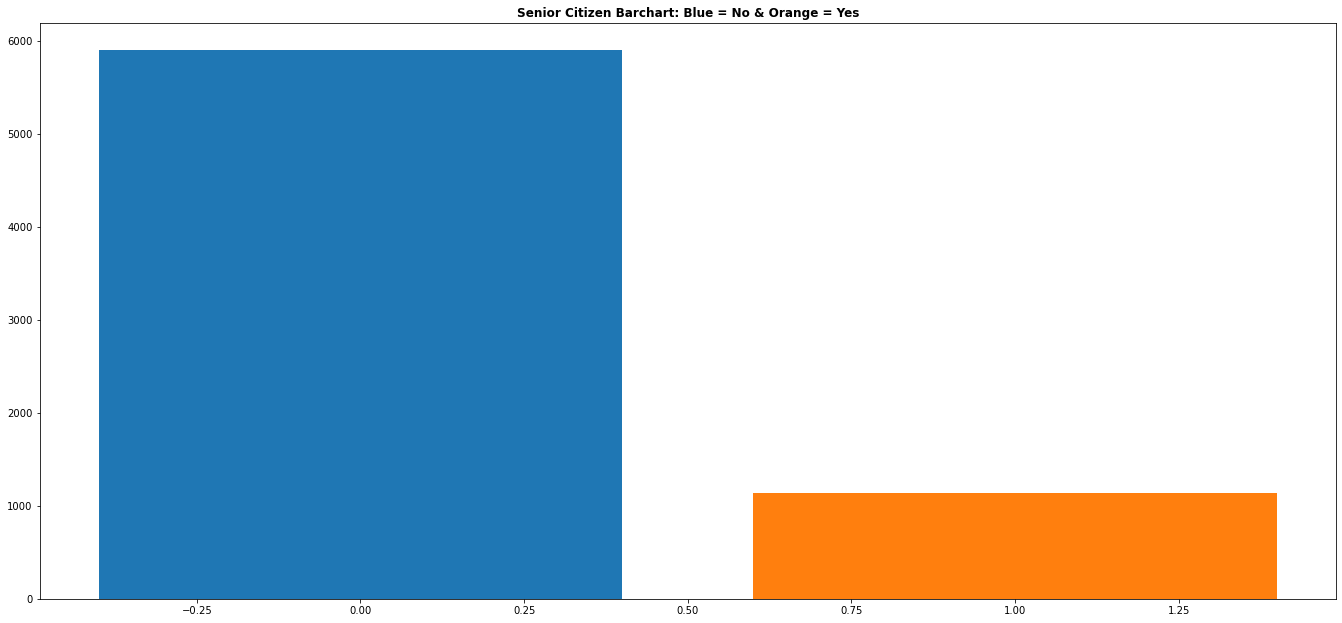

In [26]:
#barchart for Churn

data = df_Telco_training.groupBy(df_Telco_training.SeniorCitizen.cast(IntegerType())).count().orderBy("count", ascending=False).collect()
fig = plt.figure()
ax = fig.add_axes([0,0,3,2])
# add_axes([left, bottom, width, height]) to add an axes onto a fig . 
# This function enables arbitrary layouts of axes on fig by taking the dimensions ( [left, bottom, width, height] ) of the new axes
for _ in data:

  ax.bar(_[0], _[1])

  print(_)

   
print(data)

plt.title('Senior Citizen Barchart: Blue = No & Orange = Yes',fontweight ="bold")

plt.show()

Row(CAST(ChurnLabel AS INT)=0, count=5174)
Row(CAST(ChurnLabel AS INT)=1, count=1869)
[Row(CAST(ChurnLabel AS INT)=0, count=5174), Row(CAST(ChurnLabel AS INT)=1, count=1869)]


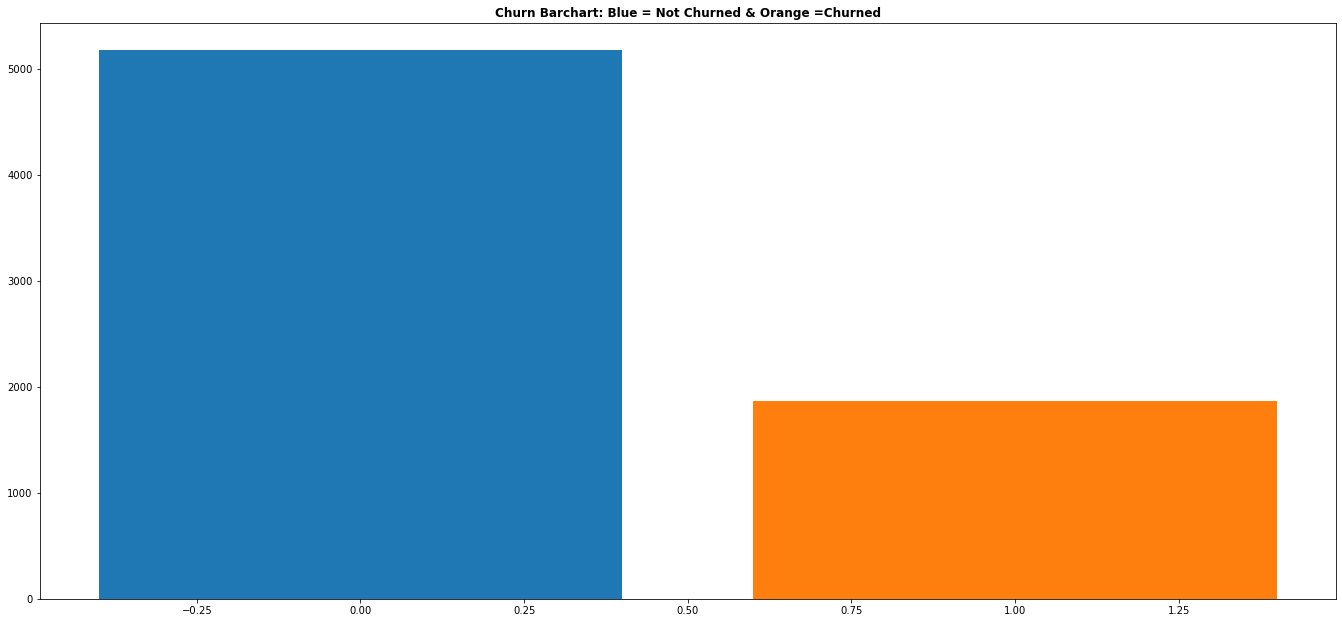

In [27]:
#barchart for Churn

data = df_Telco_training.groupBy(df_Telco_training.ChurnLabel.cast(IntegerType())).count().orderBy("count", ascending=False).collect()
fig = plt.figure()
ax = fig.add_axes([0,0,3,2])
# add_axes([left, bottom, width, height]) to add an axes onto a fig . 
# This function enables arbitrary layouts of axes on fig by taking the dimensions ( [left, bottom, width, height] ) of the new axes
for _ in data:

  ax.bar(_[0], _[1])

  print(_)

   
print(data)

plt.title('Churn Barchart: Blue = Not Churned & Orange =Churned',fontweight ="bold")

plt.show()

<Figure size 432x288 with 0 Axes>

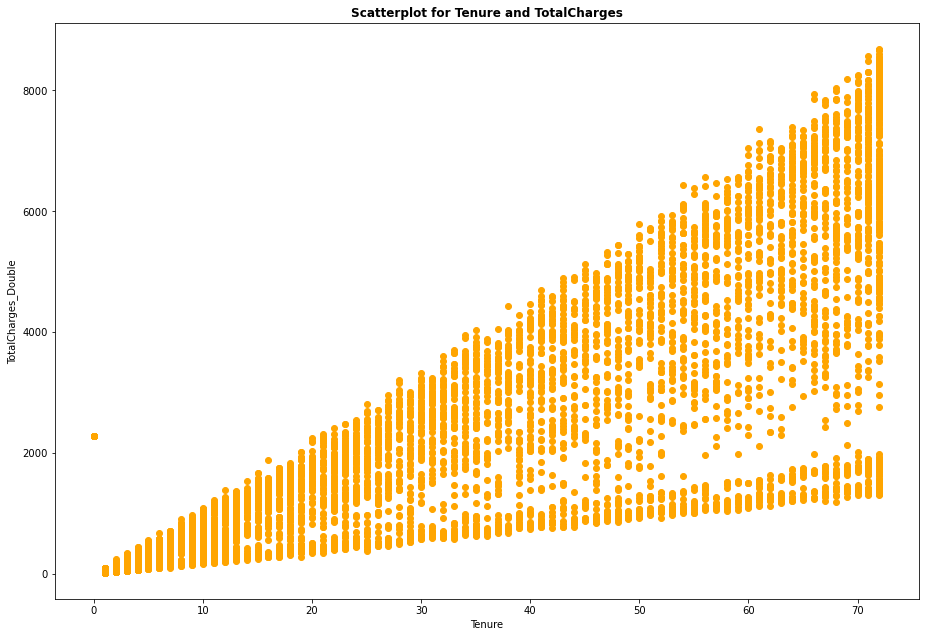

In [28]:
#Scatter plot of Tenure and TotalCharges
plt.clf()

data = df_Telco.select(df_Telco.tenure.cast(IntegerType()), func.col("TotalCharges_Double").cast(IntegerType())).collect()

fig = plt.figure()
ax = fig.add_axes([0,0,2,2])



tenure = []
TotalCharges_Double = []
for _ in data:

  TotalCharges_Double.append(_[1])

  tenure.append(_[0])

   
plt.xlabel('Tenure')
plt.ylabel('TotalCharges_Double')


plt.scatter(tenure, TotalCharges_Double, c ="orange")

plt.title('Scatterplot for Tenure and TotalCharges',fontweight ="bold")

# To show the plot
plt.show()

# Checking for correlations of variables with Churn

In [29]:
from pyspark.sql.functions import *

In [30]:
df_Telco_training.stat.corr('TotalCharges_Double', 'ChurnLabel')

-0.19942771508831444

In [31]:
df_Telco_training.stat.corr('Contract_feature', 'ChurnLabel')

-0.341503781747469

In [32]:
df_Telco_training.stat.corr('tenure', 'ChurnLabel')

-0.35222867011307885

In [33]:
df_Telco_training.stat.corr('TechSupport_feature', 'ChurnLabel')

-0.3298522644699351

In [34]:
df_Telco_training.stat.corr('SeniorCitizen', 'ChurnLabel')

0.15088932817647233

In [35]:
df_Telco_training.stat.corr('Gender_feature', 'ChurnLabel')

0.008612095078997779

In [36]:
df_Telco_training.stat.corr('StreamingMovies_feature', 'ChurnLabel')

-0.20725609227308106

In [37]:
df_Telco_training.stat.corr('PhoneService_feature', 'ChurnLabel')

-0.011941980029003086

In [38]:
df_Telco_training.stat.corr('customerID_feature', 'ChurnLabel')

-0.017447211416579483

In [39]:
df_Telco_training.stat.corr('DeviceProtection_feature', 'ChurnLabel')

-0.2814648246574711

In [40]:
df_Telco_training.stat.corr('OnlineBackup_feature', 'ChurnLabel')

-0.2914489249307383

In [41]:
df_Telco_pine = df_Telco_training.withColumn("customerID_double",func.col("customerID").cast(DoubleType()))

In [42]:
imptr = Imputer(inputCols=['TotalCharges_Double'], outputCols=['TotalCharges_Double']).setStrategy('mean')

df_Telco = imptr.fit(df_Telco).transform(df_Telco)

# Selecting features for vector Assembly

In [43]:
from pyspark.ml.feature import VectorAssembler

featureAssembler = VectorAssembler(inputCols = ['Contract_feature', 'TotalCharges_Double', 'tenure','DeviceProtection_feature', 'TechSupport_feature'] , outputCol='features')

df_Telco_training = featureAssembler.transform(df_Telco_pine)

df_Telco_training.show(5)

22/04/13 17:30:17 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+----------+------+-------------+----------+------+------------+----------------+------------+----------------+-----------+---------------+--------------+----------------+--------------------+------------+-----+-------------------+------------------+----------+--------------+----------------+-------------------+-----------------------+--------------------+------------------------+--------------------+-----------------+--------------------+
|customerID|gender|SeniorCitizen|Dependents|tenure|PhoneService|   MultipleLines|OnlineBackup|DeviceProtection|TechSupport|StreamingMovies|      Contract|PaperlessBilling|       PaymentMethod|TotalCharges|Churn|TotalCharges_Double|customerID_feature|ChurnLabel|Gender_feature|Contract_feature|TechSupport_feature|StreamingMovies_feature|PhoneService_feature|DeviceProtection_feature|OnlineBackup_feature|customerID_double|            features|
+----------+------+-------------+----------+------+------------+----------------+------------+----------------+-

In [44]:
df_Telco_training_output = df_Telco_training.select(['ChurnLabel', 'features'])
df_Telco_training_output.show(5)

+----------+--------------------+
|ChurnLabel|            features|
+----------+--------------------+
|       0.0|(5,[1,2],[29.85,1...|
|       0.0|[2.0,1889.5,34.0,...|
|       1.0|(5,[1,2],[108.15,...|
|       0.0|[2.0,1840.75,45.0...|
|       1.0|(5,[1,2],[151.65,...|
+----------+--------------------+
only showing top 5 rows



# Splitting data for Training and Testing

In [45]:
Training_df, Testing_df = df_Telco_training_output.randomSplit([0.7, 0.3])

In [46]:
Training_df.select(['ChurnLabel', 'features']).show(5)

+----------+--------------------+
|ChurnLabel|            features|
+----------+--------------------+
|       0.0|(5,[1,2],[24.2,1.0])|
|       0.0|(5,[1,2],[24.4,1.0])|
|       0.0|(5,[1,2],[24.7,1.0])|
|       0.0|(5,[1,2],[25.15,1...|
|       0.0|(5,[1,2],[29.85,1...|
+----------+--------------------+
only showing top 5 rows



In [47]:
Testing_df.select(['ChurnLabel', 'features'])

DataFrame[ChurnLabel: double, features: vector]

# Decision Tree Model

In [48]:
#PREDICTION & ACCURACY CHECK
# Create DecisionTreeClassifier
from pyspark.ml.classification import DecisionTreeClassifier

from pyspark.ml.evaluation import MulticlassClassificationEvaluator

dtc = DecisionTreeClassifier(labelCol="ChurnLabel",featuresCol="features",)



# Fit dataframe to the DecisionTreeClassifier 

dtc = dtc.fit(Training_df)



# Make predictions.

pred = dtc.transform(Testing_df)

pred.show(10)

+----------+--------------------+-------------+--------------------+----------+
|ChurnLabel|            features|rawPrediction|         probability|prediction|
+----------+--------------------+-------------+--------------------+----------+
|       0.0|(5,[1,2],[24.4,1.0])|[310.0,569.0]|[0.35267349260523...|       1.0|
|       0.0|(5,[1,2],[24.4,1.0])|[310.0,569.0]|[0.35267349260523...|       1.0|
|       0.0|(5,[1,2],[24.7,1.0])|[310.0,569.0]|[0.35267349260523...|       1.0|
|       0.0|(5,[1,2],[24.9,1.0])|[310.0,569.0]|[0.35267349260523...|       1.0|
|       0.0|(5,[1,2],[25.25,1...|[310.0,569.0]|[0.35267349260523...|       1.0|
|       0.0|(5,[1,2],[25.25,1...|[310.0,569.0]|[0.35267349260523...|       1.0|
|       0.0|(5,[1,2],[25.35,1...|[310.0,569.0]|[0.35267349260523...|       1.0|
|       0.0|(5,[1,2],[29.9,1.0])|[310.0,569.0]|[0.35267349260523...|       1.0|
|       0.0|(5,[1,2],[38.45,2...|[310.0,569.0]|[0.35267349260523...|       1.0|
|       0.0|(5,[1,2],[44.3,1.0])|[310.0,

# Evalutaion of model performance

In [49]:
tp = pred.filter((pred.ChurnLabel == 1) & (pred.prediction == 1)).count()

tn = pred.filter((pred.ChurnLabel == 0) & (pred.prediction == 0)).count()

fp = pred.filter((pred.ChurnLabel == 0) & (pred.prediction == 1)).count()

fn = pred.filter((pred.ChurnLabel == 1) & (pred.prediction == 0)).count()



print("True Positives:", tp)

print("True Negatives:", tn)

print("False Positives:", fp)

print("False Negatives:", fn)



a = ((tp + tn)/pred.count()) #accuracy

r = float(tp) / (tp + fn)  #Recall

p = float(tp) / (tp + fp)  #Precision

f1 = 2 * ((p * r)/(p + r))  



print("Accuracy:", a)

print("Recall:", r)

print("Precision:", p)

print("F1 score:", f1)

True Positives: 253
True Negatives: 1422
False Positives: 190
False Negatives: 298
Accuracy: 0.7743874248728617
Recall: 0.4591651542649728
Precision: 0.5711060948081265
F1 score: 0.5090543259557345
